In [1]:
import sys
sys.path.append("..")

import dill
import pandas as pd
from pymongo import MongoClient
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score
import datetime as dt
import numpy as np
from buildmodel.get_sample_data import get_data_from_mongo
from pipeline.meetup_pipeline import interest, random_forest_model, log_word_count, meetup_union
import matplotlib.pyplot as plt
from nltk import word_tokenize

%matplotlib inline

/home/cb/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
mc = MongoClient()
db = mc['meetups']
events = db['past_3years_meetup_events']
groups = db['groups']
ed = db['events_data']

In [5]:
events.find_one()['header']

{'Content-Type': 'application/json;charset=utf-8',
 'Server': 'Apache-Coyote/1.1',
 'X-Meetup-server': '41dac884245a',
 'X-Meetup-Request-ID': '5bdab70d-37fe-42ff-9ea9-c5e525a01254',
 'X-OAuth-Scopes': 'basic',
 'X-Accepted-OAuth-Scopes': 'basic',
 'X-RateLimit-Limit': '30',
 'X-RateLimit-Remaining': '29',
 'X-RateLimit-Reset': '10',
 'X-Total-Count': '28',
 'ETag': '"c1f4ba8dd400c0dd59ada456f0dddb16-gzip"',
 'Content-Encoding': 'gzip',
 'Content-Length': '29390',
 'Accept-Ranges': 'bytes',
 'Date': 'Fri, 17 Aug 2018 21:59:11 GMT',
 'Via': '1.1 varnish',
 'Connection': 'keep-alive',
 'X-Served-By': 'cache-yvr6927-YVR',
 'X-Cache': 'MISS',
 'X-Cache-Hits': '0',
 'X-Timer': 'S1534543150.395389,VS0,VE1505',
 'Vary': 'Accept-Encoding,User-Agent,Accept-Language'}

In [14]:
groups_lst = []
for group in groups.find():
    groups_lst.append(group['data'])
groups_df = pd.DataFrame(groups_lst)

In [16]:
200* 29-10

5790

In [6]:
shard = get_data_from_mongo(0.5)

In [7]:
df = pd.DataFrame(shard)

In [8]:
df.to_csv('../../data/data.gzip', compression='gzip')

In [2]:
meetup_data = pd.read_csv('../../data/data.gzip', compression='gzip')

/home/cb/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
df.isnull().sum()

_id                                      0
created                              35824
description                          38612
description_images                   35824
duration                             62071
event_hosts                          47709
featured                             35824
featured_photo                      145322
fee                                 147257
fee_options                          35824
group                                   27
how_to_find_us                      107196
id                                      27
link                                    27
local_date                              27
local_time                              27
manual_attendance_count             150887
name                                    27
plain_text_no_images_description     35824
pro_is_email_shared                 152741
rsvp_close_offset                   149762
rsvp_limit                          129577
rsvp_open_offset                    153782
rsvp_rules 

In [3]:
no_null_lables = drop_null_labels(meetup_data)

Removing all samples that don't have a label, these might be private events.

In [8]:
no_null_lables.isnull().sum()

_id                                      0
created                              35797
description                          38585
description_images                   35797
duration                             62044
event_hosts                          47682
featured                             35797
featured_photo                      145295
fee                                 147230
fee_options                          35797
group                                    0
how_to_find_us                      107169
id                                       0
link                                     0
local_date                               0
local_time                               0
manual_attendance_count             150860
name                                     0
plain_text_no_images_description     35797
pro_is_email_shared                 152714
rsvp_close_offset                   149735
rsvp_limit                          129550
rsvp_open_offset                    153755
rsvp_rules 

In [123]:
visibility_nulls = no_null_lables[no_null_lables['created'].isnull()]

In [11]:
visibility_nulls.isnull().sum()

_id                                     0
created                             35797
description                         35797
description_images                  35797
duration                            15414
event_hosts                         35797
featured                            35797
featured_photo                      35797
fee                                 35797
fee_options                         35797
group                                   0
how_to_find_us                      35797
id                                      0
link                                    0
local_date                              0
local_time                              0
manual_attendance_count             35797
name                                    0
plain_text_no_images_description    35797
pro_is_email_shared                 35797
rsvp_close_offset                   35797
rsvp_limit                          35797
rsvp_open_offset                    35797
rsvp_rules                        

In [124]:
no_limited_viz = no_null_lables[no_null_lables['visibility'] != 'public_limited']

In [175]:
no_limited_viz.isnull().sum()

_id                                      0
created                                  0
description                           2788
description_images                       0
duration                             46630
event_hosts                          11885
featured                                 0
featured_photo                      109498
fee                                 111433
fee_options                              0
group                                    0
how_to_find_us                       71372
id                                       0
link                                     0
local_date                               0
local_time                               0
manual_attendance_count             115063
name                                     0
plain_text_no_images_description         0
pro_is_email_shared                 116917
rsvp_close_offset                   113938
rsvp_limit                           93753
rsvp_open_offset                    117958
rsvp_rules 

Description nans are '' or I don't have access to them

Text(0,0.5,'frequency')

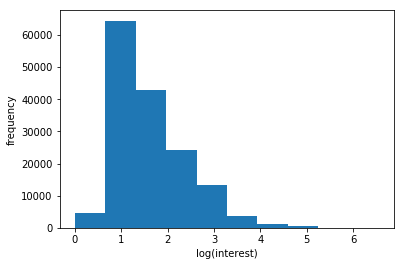

In [29]:
plt.hist(np.log(interest.fit_transform(no_null_lables)+1))
plt.xlabel('log(interest)')
plt.ylabel('frequency')

In [18]:
no_null_lables.describe()['yes_rsvp_count']

count    155359.000000
mean          6.593303
std          12.925321
min           0.000000
25%           1.000000
50%           3.000000
75%           7.000000
max         704.000000
Name: yes_rsvp_count, dtype: float64

In [24]:
no_null_lables.sort_values('yes_rsvp_count', ascending=False).loc[132383, 'link']

'https://www.meetup.com/Seattle-Unreal-Engine-4-Meetup/events/233252433/'

In [28]:
np.log(750)

6.620073206530356

In [4]:
X_train, X_test, y_train, y_test = train_test_split(no_null_lables, interest.fit_transform(no_null_lables), random_state=1969)

In [38]:
cross_val_score(meetup_model, X_train, y_train)

array([0.3778215 , 0.37995518, 0.39030371])

In [40]:
cross_val_score(meetup_model, X_train, y_train)

array([0.24023329, 0.27433533, 0.23684761])

log(label+1) increases R^2 score by a decent amount, it's being added to the pipeline

# Days of the week

In [8]:
dow = day_and_month.fit_transform(X_train)

(array([12328., 16959.,     0., 18705.,     0., 17339., 12616.,     0.,
        21986., 16586.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

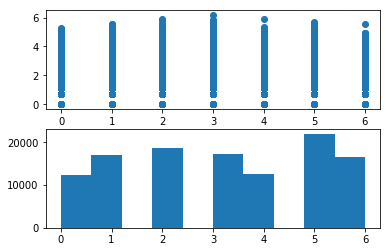

In [16]:
fig, axs = plt.subplots(2)

axs[0].scatter(dow, y_train)
axs[1].hist(dow)

In [11]:
check_dow = pd.concat([dow, pd.Series(y_train)], axis=1)

TypeError: cannot concatenate object of type "<class 'numpy.ndarray'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid

In [33]:
check_dow.groupby('local_date').mean()[0].map(lambda x: np.e**x -1)

local_date
0    3.051491
1    3.562786
2    3.459777
3    3.405334
4    3.906674
5    4.267080
6    3.774816
Name: 0, dtype: float64

In [34]:
list(range(7))

[0, 1, 2, 3, 4, 5, 6]

In [35]:
day_and_month(dow)

[autoreload of pipeline.meetup_pipeline failed: Traceback (most recent call last):
  File "/home/cb/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/cb/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/home/cb/anaconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/cb/anaconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "../pipeline/meetup_pipeline.py", line 34, in <module>
    ('one_hotify', EncodeFeature(range(7)))
NameError: name 'EncodeFeature' is not defined
]


TypeError: 'Pipeline' object is not callable

In [13]:
dow.shape

(116519, 7)

In [14]:
cross_val_score(meetup_model, X_train, y_train)

array([0.37478107, 0.38098821, 0.39191901])

# Months of the year

In [17]:
month_of_year = pd.to_datetime(X_train['local_date']).dt.month

(array([18334., 10200., 10209., 10552., 10547., 10697.,  9850.,  9440.,
         9614., 17076.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

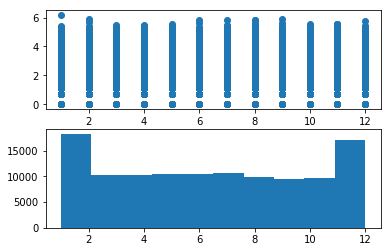

In [19]:
fig, axs = plt.subplots(2)

axs[0].scatter(month_of_year, pd.Series(y_train))
axs[1].hist(month_of_year)

month doesn't appear to have influence

In [6]:
cross_val_score(meetup_model, X_train, y_train, scoring='neg_mean_squared_error')

array([-0.48317253, -0.48183024, -0.47748917])

In [24]:
month_of_year.fit_transform(X_train).sum(axis=0)

array([ 9173,  9161, 10200, 10209, 10552, 10547, 10697,  9850,  9440,
        9614,  8906,  8170])

# Time of day

In [137]:
time_of_day = X_train['local_time'].apply(pd.to_datetime).dt.hour.rename('tod')
dow = pd.to_datetime(X_train['local_date']).dt.dayofweek.rename('dow')

(array([1.0600e+02, 2.9000e+01, 1.3230e+03, 1.5107e+04, 1.8944e+04,
        1.2146e+04, 9.3530e+03, 3.1887e+04, 2.6229e+04, 1.3950e+03]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <a list of 10 Patch objects>)

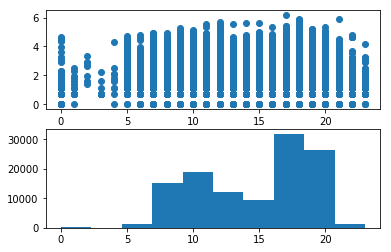

In [138]:
fig, axs = plt.subplots(2)

axs[0].scatter(time_of_day, pd.Series(y_train))
axs[1].hist(time_of_day)

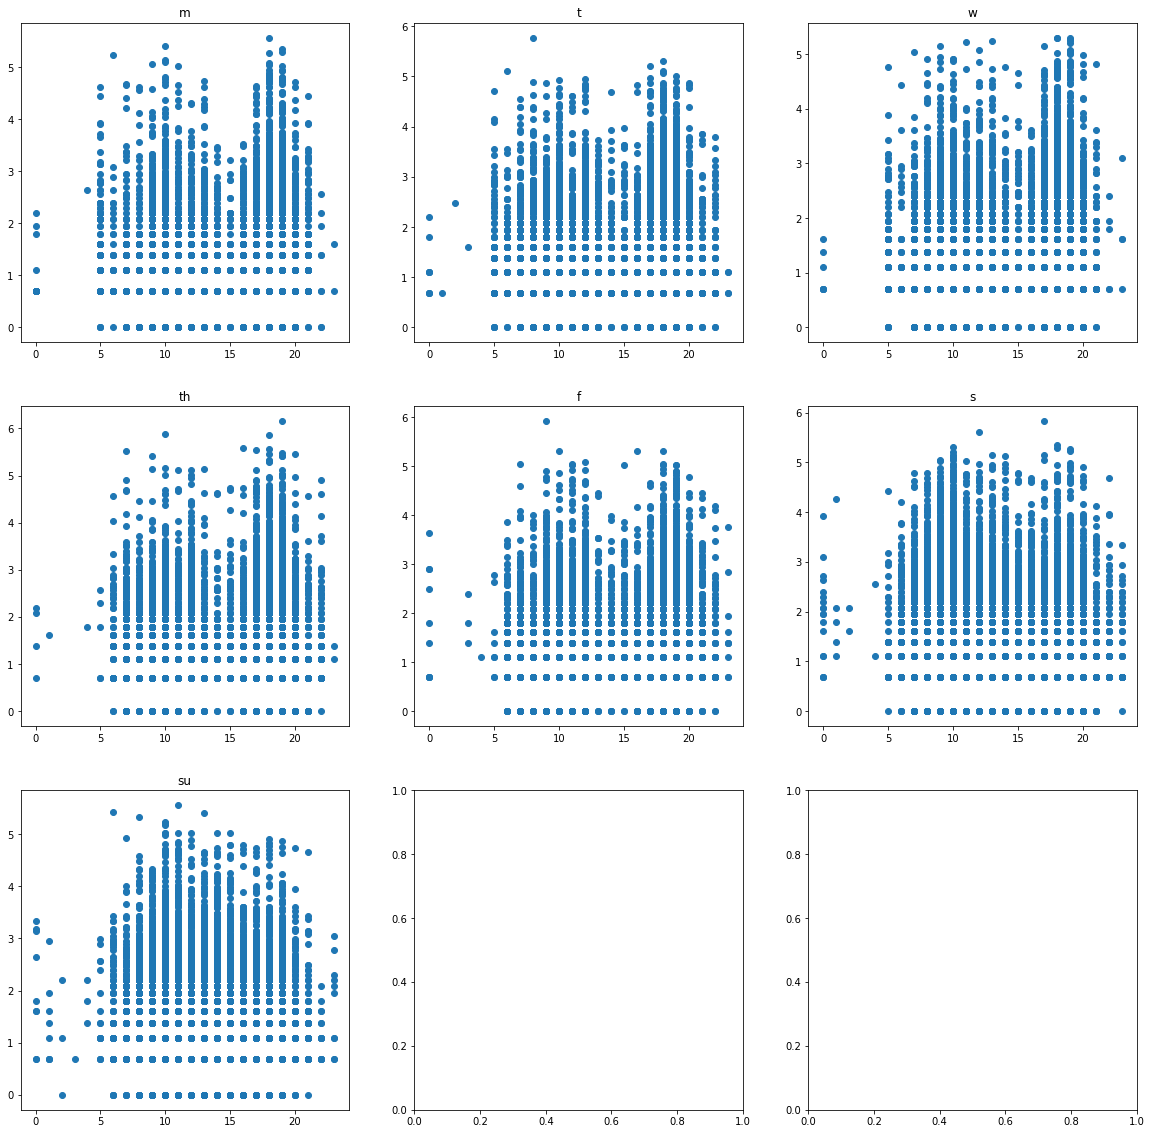

In [139]:
time_and_day = pd.concat([time_of_day, dow, pd.Series(y_train)], axis=1, names=['tod', 'dow', 'y'])
fig, axs = plt.subplots(3,3, figsize=(20,20))
names = ['m', 't', 'w', 'th', 'f', 's', 'su']
for day, ax in zip(range(7), axs.flatten()[:7]): 
    day_frame = time_and_day[time_and_day['dow']==day]
    ax.scatter(day_frame['tod'], day_frame[0])
    ax.set_title(names[day])

In [ ]:
cross_val_score(meetup_model, X_train, y_train, scoring='neg_mean_squared_error')

# length of description

In [37]:
X_train.loc[:,'plain_text_no_images_description'] = X_train.loc[:,'plain_text_no_images_description'].fillna('')
X_train.loc[:,'plain_text_no_images_description'] = X_train.loc[:,'plain_text_no_images_description'].map(lambda x: x.replace('\n', ' '))

/home/cb/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [45]:
X_train['word_count'] = X_train['plain_text_no_images_description'].map(lambda x: len(word_tokenize(x)))

/home/cb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


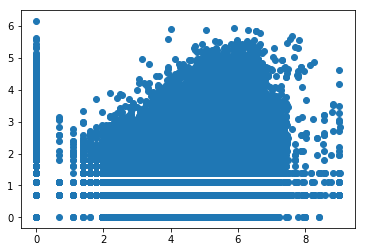

In [50]:
fig, ax = plt.subplots()

ax.scatter(np.log(X_train['word_count']+1), y_train)

(array([29095.,   544.,  2043.,  7765., 21849., 33686., 17777.,  3296.,
          373.,    91.]),
 array([0.        , 0.9030376 , 1.80607521, 2.70911281, 3.61215041,
        4.51518802, 5.41822562, 6.32126322, 7.22430083, 8.12733843,
        9.03037603]),
 <a list of 10 Patch objects>)

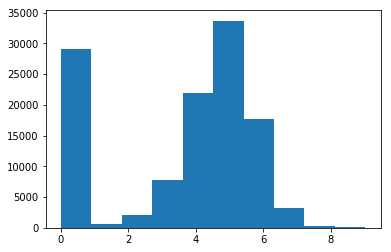

In [49]:
plt.hist(np.log(X_train['word_count']+1))

In [16]:
cross_val_score(meetup_model, X_train, y_train, scoring='neg_mean_squared_error')

array([-0.48317253, -0.48183024, -0.47748917])

In [6]:
cross_val_score(meetup_model, X_train, y_train, scoring='neg_mean_squared_error')

array([-0.47307179, -0.47349933, -0.47374383])

In [7]:
.473**0.5

0.687749954561976

In [9]:
day_of_week.fit_transform(X_train)

array([[False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True],
       [False,  True, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False]])

In [5]:
meetup_union.fit_transform(X_train)

<116519x144 sparse matrix of type '<class 'numpy.float64'>'
	with 1562570 stored elements in Compressed Sparse Row format>

In [ ]:
cross_val_score(meetup_model, X_train, y_train, scoring='neg_mean_squared_error')

In [ ]:
groups